In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 71kB 2.3MB/s 
     |████████████████████████████████| 778kB 9.2MB/s 
     |████████████████████████████████| 3.0MB 22.7MB/s 
     |████████████████████████████████| 1.1MB 42.3MB/s 
     |████████████████████████████████| 890kB 20.2MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.3-cp36-none-any.whl size=97299 sha256=c394307dca857eae8b658d8b2f36e7062976ca7e4ac4d38b30d281db3ad1d8b3
  Stored in directory: /root/.cache/pip/wheels/75/d6/0a/cab163b21d0597cc1580bc344487b11ad405e0d1d314725f2b
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=c0e8a2f96a869e8c8b7a60a13f9df86f8d6bc0c5f6b4a4c8fd08e29abfbb16c0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


## Importing dependencies

In [ ]:
import os
import random
import functools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import interpolate
from torch.nn.modules.utils import _pair
from numpy import sqrt, prod
import torchvision
import torchvision.transforms as transforms

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Incubator/scripts')

In [ ]:
from preprocess import get_weighted_dataloader, extract_zip
from text_encoder.sentence_encoder import SentenceEncoder

# Initialize Constants

In [ ]:
noise_size = 100
image_size = 256
batch_size = 16
num_channels = 3
subset_size = 20_000
epochs = 20
KL_COE = 4
n_critic = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Extract Zip

In [ ]:
# extract_zip('/content/drive/My Drive/Incubator/Datasets/celeba-dataset.zip', '.')

# Create Sentence Encoder

In [ ]:
sentence_encoder = SentenceEncoder(device)

100%|██████████| 405M/405M [00:20<00:00, 20.2MB/s]


## Data Loading

In [ ]:
attributes_df = pd.read_csv('/content/drive/My Drive/Incubator/Datasets/list_attr_celeba.csv')

In [ ]:
text_desc_df = pd.read_csv('/content/drive/My Drive/Incubator/Datasets/text_descr_celeba.csv')

In [ ]:
drop_cols = {'Bags_Under_Eyes', 'Bangs', 'Blurry', 'No_Beard'}

In [ ]:
attributes_df = attributes_df.drop(columns = drop_cols)

In [ ]:
only_attributes = attributes_df.drop(columns = 'image_id')

In [ ]:
classes = set(only_attributes)

In [ ]:
print('Classes present: ', classes)
print('Number of classes: ', len(classes))

Classes present:  {'Double_Chin', 'Rosy_Cheeks', 'Sideburns', 'Arched_Eyebrows', 'Big_Nose', 'Mustache', 'Oval_Face', 'Bald', 'Straight_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Necktie', 'Narrow_Eyes', 'Wearing_Necklace', 'Gray_Hair', 'Pointy_Nose', 'Big_Lips', 'Mouth_Slightly_Open', 'Chubby', 'Wavy_Hair', 'Blond_Hair', 'Heavy_Makeup', 'Pale_Skin', 'High_Cheekbones', 'Smiling', 'Attractive', 'Eyeglasses', 'Black_Hair', 'Brown_Hair', 'Goatee', 'Receding_Hairline', 'Male', '5_o_Clock_Shadow', 'Bushy_Eyebrows', 'Young', 'Wearing_Lipstick'}
Number of classes:  36


## Helper functions

In [ ]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

## Initialize constants

## Creating a Custom Dataset class

In [ ]:
from collections import OrderedDict

In [ ]:
class ImageTextDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, csv_file, image_sizes):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.text_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.image_sizes = image_sizes

    def __len__(self):
        return len(self.text_df)

    def __getitem__(self, idx):

        real_dict = OrderedDict()
        wrong_dict = OrderedDict()

        if torch.is_tensor(idx):
            idx = idx.tolist()
        # real images
        img_name = os.path.join(self.root_dir,
                                self.text_df.iloc[idx, 0])
        image = Image.open(img_name)

        text = self.text_df.iloc[idx, 1:].values[0]

        for size in self.image_sizes:
            transform = transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))])
            r_image = transform(image)
            real_dict[f'output_{size}'] = r_image

        # fake images
        wrong_idx = random.randint(0, 202599 - 1)
        while wrong_idx == idx:
            wrong_idx = random.randint(0, 202599 - 1)
        wrong_img_name = os.path.join(self.root_dir,
                                self.text_df.iloc[wrong_idx, 0])
        wrong_image = Image.open(wrong_img_name)

        for size in self.image_sizes:
            transform = transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))])
            w_image = transform(wrong_image)
            wrong_dict[f'output_{size}'] = w_image

        return real_dict, text, wrong_dict

In [ ]:
dataset = ImageTextDataset('/content/img_align_celeba/img_align_celeba',  
                           '/content/drive/My Drive/Incubator/Datasets/text_descr_celeba.csv',
                            [64, 128, 256]
                           )

## Creating subset of dataset

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
random_indices = torch.randperm(subset_size)
print(len(random_indices))

20000


In [ ]:
only_attributes = only_attributes.iloc[random_indices]
print('Length of subset dataset ', len(only_attributes))

Length of subset dataset  20000


## Weights on classes

In [ ]:
def generate_weights(arr, num_classes):
  # To get the count of each label
  counts = np.zeros(num_classes)
  for row in tqdm(arr):
    idxs = np.where(row == 1)
    counts[idxs] += 1

  # Calculating weight per class
  N = float(sum(counts))
  weight_per_class = np.zeros(num_classes)
  for i in range(num_classes):
    weight_per_class[i]  = N / counts[i]

  # Calculating final weights
  weights = [0.0] * len(arr)
  for i, row in tqdm(enumerate(arr)):
    idxs = np.where(row == 1)
    weights[i] = sum(weight_per_class[idxs])
  return weights

In [ ]:
weights = generate_weights(only_attributes.values, len(classes))

In [ ]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

## Converting to dataloader

In [ ]:
subset_dataset = torch.utils.data.Subset(dataset, random_indices)

In [ ]:
weighted_dataloader = torch.utils.data.DataLoader(subset_dataset, batch_size = batch_size, shuffle = False, sampler = sampler, pin_memory = True)

In [ ]:
len(weighted_dataloader)

1250

## Testing dataloader output

In [ ]:
weighted_dataiter = iter(weighted_dataloader)

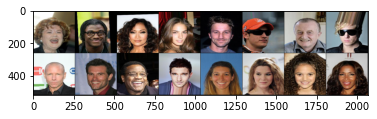

['The woman has a chubby face, has a double chin and pretty high cheekbones. Her hair is brown and wavy. She has arched eyebrows, a slightly open mouth, narrow eyes and a pointy nose. The lady is smiling. She is wearing earrings and a necklace.', 'The gentleman has high cheekbones. His hair is black. He has big lips, a big nose and a slightly open mouth. The man is smiling. He is wearing eyeglasses and a necklace.', 'The woman has high cheekbones and an oval face. Her hair is wavy. She has arched eyebrows, bushy eyebrows and narrow eyes. The woman is smiling, looks attractive, young and has heavy makeup. She is wearing earrings and lipstick.', 'She has brown and wavy hair. She has a slightly open mouth and a pointy nose. The woman looks attractive, young and has heavy makeup. She is wearing lipstick.', "The male has an oval face. He sports a 5 o' clock shadow. The man is attractive and young is smiling.", 'The gentleman seems young. He is wearing eyeglasses and a hat.', 'The male has h

In [ ]:
images, labels, _ = weighted_dataiter.next()
show_grid(torchvision.utils.make_grid(images[f'output_{image_size}'], normalize=True))
print(labels)

## Creating BERT sent embeddings

In [ ]:
output = sentence_encoder.convert_text_to_embeddings(labels)
print(output)
print(output.shape)

tensor([[ 0.3771,  0.0074, -0.2570,  ..., -0.0527,  0.2629,  0.1275],
        [ 0.3293,  0.1506,  0.0924,  ...,  0.0525,  0.1873, -0.2692],
        [ 0.4047, -0.2274, -0.0564,  ..., -0.4890,  0.0897,  0.0511],
        ...,
        [ 0.2485, -0.3911, -0.1056,  ..., -0.6269, -0.0589,  0.1452],
        [ 0.2103, -0.3784,  0.2089,  ..., -0.4853,  0.0489,  0.1149],
        [ 0.2465, -0.1532, -0.2099,  ..., -0.5064,  0.0445, -0.1494]],
       device='cuda:0')
torch.Size([16, 768])


# Network Helpers

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        if hasattr(m, 'weight'):
            m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1: 
        # Estimated variance, must be around 1
        m.weight.data.normal_(1.0, 0.02)
        # Estimated mean, must be around 0
        m.bias.data.fill_(0)

In [ ]:
def pad_conv_norm(dim_in, dim_out, norm_layer, kernel_size=3, use_activation=True, 
                  use_bias=False, activation=nn.ReLU(True)):
    # designed for generators
    seq = []
    if kernel_size != 1:
        seq += [nn.ReflectionPad2d(1)]
        
    seq += [nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, padding=0, bias=use_bias),
            norm_layer(dim_out)]
    
    if use_activation:
        seq += [activation]
    
    return nn.Sequential(*seq)

In [ ]:
def conv_norm(dim_in, dim_out, norm_layer, kernel_size=3, stride=1, use_activation=True, 
              use_bias=False, activation=nn.ReLU(True), use_norm=True,padding=None):
    # designed for discriminator
    
    if kernel_size == 3:
        padding = 1 if padding is None else padding
    else:
        padding = 0 if padding is None else padding

    seq = [nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, padding=padding, bias=use_bias, stride=stride),
           ]
    if use_norm:
        seq += [norm_layer(dim_out)]
    if use_activation:
        seq += [activation]
    
    return nn.Sequential(*seq)

In [ ]:
def branch_out(in_dim, out_dim=3):
    _layers = [ nn.ReflectionPad2d(1),
                nn.Conv2d(in_dim, out_dim, 
                kernel_size = 3, padding=0, bias=False)]    
    _layers += [nn.Tanh()]

    return nn.Sequential(*_layers)

# HDGAN Architecture

## Layers

In [ ]:
class condEmbedding(nn.Module):
    def __init__(self, noise_dim, emb_dim):
        super(condEmbedding, self).__init__()

        self.noise_dim = noise_dim
        self.emb_dim = emb_dim
        self.linear  = nn.Linear(noise_dim, emb_dim*2)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def sample_encoded_context(self, mean, logsigma, kl_loss=False):
    
        epsilon = torch.cuda.FloatTensor(mean.size()).normal_()
        stddev  = logsigma.exp()
        
        return epsilon.mul(stddev).add_(mean)

    def forward(self, inputs, kl_loss=True):
        '''
        inputs: (B, dim)
        return: mean (B, dim), logsigma (B, dim)
        '''
        out = self.relu(self.linear(inputs))
        mean = out[:, :self.emb_dim]
        log_sigma = out[:, self.emb_dim:]

        c = self.sample_encoded_context(mean, log_sigma)
        return c, mean, log_sigma

In [ ]:
class ImageDown(torch.nn.Module):

    def __init__(self, input_size, num_chan, out_dim):
        """
            Parameters:
            ----------
            input_size: int
                input image size, can be 64, or 128, or 256
            num_chan: int
                channel of input images.
            out_dim : int
                the dimension of generated image code.
        """

        super(ImageDown, self).__init__()
        self.__dict__.update(locals())

        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
        activ = nn.LeakyReLU(0.2, True)

        _layers = []
        # use large kernel_size at the end to prevent using zero-padding and stride
        if input_size == 64:
            cur_dim = 128
            _layers += [conv_norm(num_chan, cur_dim, norm_layer, stride=2, activation=activ, use_norm=False)]  # 32
            _layers += [conv_norm(cur_dim, cur_dim*2, norm_layer, stride=2, activation=activ)]  # 16
            _layers += [conv_norm(cur_dim*2, cur_dim*4, norm_layer, stride=2, activation=activ)]  # 8
            _layers += [conv_norm(cur_dim*4, out_dim,  norm_layer, stride=1, activation=activ, kernel_size=5, padding=0)]  # 4

        if input_size == 128:
            cur_dim = 64
            _layers += [conv_norm(num_chan, cur_dim, norm_layer, stride=2, activation=activ, use_norm=False)]  # 64
            _layers += [conv_norm(cur_dim, cur_dim*2, norm_layer, stride=2, activation=activ)]  # 32
            _layers += [conv_norm(cur_dim*2, cur_dim*4, norm_layer, stride=2, activation=activ)]  # 16
            _layers += [conv_norm(cur_dim*4, cur_dim*8, norm_layer, stride=2, activation=activ)]  # 8
            _layers += [conv_norm(cur_dim*8, out_dim,  norm_layer, stride=1, activation=activ, kernel_size=5, padding=0)]  # 4

        if input_size == 256:
            cur_dim = 32 # for testing
            _layers += [conv_norm(num_chan, cur_dim, norm_layer, stride=2, activation=activ, use_norm=False)] # 128
            _layers += [conv_norm(cur_dim, cur_dim*2,  norm_layer, stride=2, activation=activ)] # 64
            _layers += [conv_norm(cur_dim*2, cur_dim*4,  norm_layer, stride=2, activation=activ)] # 32
            _layers += [conv_norm(cur_dim*4, cur_dim*8,  norm_layer, stride=2, activation=activ)] # 16
            _layers += [conv_norm(cur_dim*8, out_dim,  norm_layer, stride=2, activation=activ)] # 8

        self.node = nn.Sequential(*_layers)

    def forward(self, inputs):

        out = self.node(inputs)
        return out

In [ ]:
class DiscClassifier(nn.Module):
    def __init__(self, enc_dim, emb_dim, kernel_size):
        """
            Parameters:
            ----------
            enc_dim: int
                the channel of image code.
            emb_dim: int
                the channel of sentence code.
            kernel_size : int
                kernel size used for final convolution.
        """

        super(DiscClassifier, self).__init__()
        self.__dict__.update(locals())
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
        activ = nn.LeakyReLU(0.2, True)
        inp_dim = enc_dim + emb_dim

        _layers = [conv_norm(inp_dim, enc_dim, norm_layer, kernel_size=1, stride=1, activation=activ),
                   nn.Conv2d(enc_dim, 1, kernel_size=kernel_size, padding=0, bias=True)]

        self.node = nn.Sequential(*_layers)

    def forward(self, sent_code,  img_code):

        sent_code = sent_code.unsqueeze(-1).unsqueeze(-1)
        dst_shape = list(sent_code.size())
        dst_shape[1] = sent_code.size()[1]
        dst_shape[2] = img_code.size()[2]
        dst_shape[3] = img_code.size()[3]
        sent_code = sent_code.expand(dst_shape)
        comp_inp = torch.cat([img_code, sent_code], dim=1)
        output = self.node(comp_inp)
        chn = output.size()[1]
        output = output.view(-1, chn)

        return output

In [ ]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, use_bias=False):
        super(ResnetBlock, self).__init__()
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
        activ = nn.ReLU(True)

        seq = [pad_conv_norm(dim, dim, norm_layer, use_bias=use_bias, activation=activ),
               pad_conv_norm(dim, dim, norm_layer, use_activation=False, use_bias=use_bias)]
        self.res_block = nn.Sequential(*seq)

    def forward(self, input):
        return self.res_block(input) + input

In [ ]:
class Sent2FeatMap(nn.Module):
    # used to project a sentence code into a set of feature maps
    def __init__(self, in_dim, row, col, channel, activ=None):
        super(Sent2FeatMap, self).__init__()
        self.__dict__.update(locals())
        out_dim = row*col*channel
        norm_layer = functools.partial(nn.BatchNorm1d, affine=True)
        _layers = [nn.Linear(in_dim, out_dim)]
        _layers += [norm_layer(out_dim)]
        if activ is not None:
            _layers += [activ]
        self.out = nn.Sequential(*_layers)

    def forward(self, inputs):
        output = self.out(inputs)
        output = output.view(-1, self.channel, self.row, self.col)
        return output

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, sent_dim, noise_dim, emb_dim, hid_dim, max_size, num_resblock=1):
        """
        Parameters:
        ----------
        sent_dim: int
            the dimension of sentence embedding
        noise_dim: int
            the dimension of noise input
        emb_dim : int
            the dimension of compressed sentence embedding.
        hid_dim: int
            used to control the number of feature maps.
        num_resblock: int
            the scale factor of generator (see paper for explanation).
        side_output_at:  list
            contains local loss size for discriminator at scales.
        """

        super(Generator, self).__init__()
        self.__dict__.update(locals())

        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
        act_layer = nn.ReLU(True)
        self.condEmbedding = condEmbedding(sent_dim, emb_dim)

        self.vec_to_tensor = Sent2FeatMap(
            emb_dim+noise_dim, 4, 4, self.hid_dim*8)
        
        self.max_size = max_size
        
        side_output_at = []
        if max_size >= 64:
          side_output_at.append(64)
        if max_size >= 128:
          side_output_at.append(128)
        if max_size == 256:
          side_output_at.append(256)
        self.side_output_at = side_output_at

        # feature map dimension reduce at which resolution
        reduce_dim_at = [8, 32]
        if max_size >= 128:
          reduce_dim_at.append(128)
        if max_size == 256:
          reduce_dim_at.append(256)
        # different scales for all networks
        num_scales = [4, 8, 16, 32, 64]
        if max_size >= 128:
          num_scales.append(128)
        if max_size == 256:
          num_scales.append(256)

        cur_dim = self.hid_dim*8
        for i in range(len(num_scales)):
            seq = []
            # unsampling
            if i != 0:
                seq += [nn.Upsample(scale_factor=2, mode='nearest')]
            # if need to reduce dimension
            if num_scales[i] in reduce_dim_at:
                seq += [pad_conv_norm(cur_dim, cur_dim//2,
                                      norm_layer, activation=act_layer)]
                cur_dim = cur_dim//2
            # add residual blocks
            for n in range(num_resblock):
                seq += [ResnetBlock(cur_dim)]
            # add main convolutional module
            setattr(self, 'scale_%d' % (num_scales[i]), nn.Sequential(*seq))

            if num_scales[i] in self.side_output_at:
                setattr(self, 'tensor_to_img_%d' %
                        (num_scales[i]), branch_out(cur_dim))

        self.apply(weights_init)
        print('>> Init HDGAN Generator')
        print('\t side output at {}'.format(str(side_output_at)))

    def forward(self, sent_embeddings, z):
        """
        Parameters:
        ----------
        sent_embeddings: [B, sent_dim]
            sentence embedding obtained from char-rnn
        z: [B, noise_dim]
            noise input
        Returns:
        ----------
        out_dict: dictionary
            dictionary containing the generated images at scale [64, 128, 256]
        kl_loss: tensor
            Kullback–Leibler divergence loss from conditionining embedding
        """
        
        sent_random, mean, logsigma=self.condEmbedding(sent_embeddings)
        text = torch.cat([sent_random, z], dim=1)
        x = self.vec_to_tensor(text)
        x_4 = self.scale_4(x)
        x_8 = self.scale_8(x_4)
        x_16 = self.scale_16(x_8)
        x_32 = self.scale_32(x_16)

        # skip 4x4 feature map to 32 and send to 64
        x_64 = self.scale_64(x_32)
        output_64 = self.tensor_to_img_64(x_64)
        
        if self.max_size == 64:
          return output_64, mean, logsigma

        # skip 8x8 feature map to 64 and send to 128
        x_128 = self.scale_128(x_64)
        output_128 = self.tensor_to_img_128(x_128)
        if self.max_size == 128:
          return output_64, output_128, mean, logsigma

        # skip 16x16 feature map to 128 and send to 256
        out_256 = self.scale_256(x_128)
        self.keep_out_256 = out_256
        output_256 = self.tensor_to_img_256(out_256)

        return output_64, output_128, output_256, mean, logsigma

In [ ]:
netG = Generator(sent_dim=768, noise_dim=100, emb_dim=128, hid_dim=128, max_size=image_size, num_resblock=1).cuda()

>> Init HDGAN Generator
	 side output at [64, 128, 256]


torch.Size([16, 3, 256, 256])


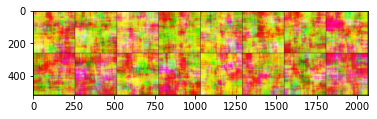

Generator(
  (condEmbedding): condEmbedding(
    (linear): Linear(in_features=768, out_features=256, bias=True)
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (vec_to_tensor): Sent2FeatMap(
    (out): Sequential(
      (0): Linear(in_features=228, out_features=16384, bias=True)
      (1): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (scale_4): Sequential(
    (0): ResnetBlock(
      (res_block): Sequential(
        (0): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): ReLU(inplace=True)
        )
        (1): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
with torch.no_grad():
    netG.eval()
    noise = torch.randn(size=(batch_size, noise_size)).cuda()
    text_embeddings = sentence_encoder.convert_text_to_embeddings(labels)
    output = netG(text_embeddings, noise)
    print(output[-3].shape)
show_grid(torchvision.utils.make_grid(output[-3].cpu().detach(), normalize=True))
netG.train()

## Discriminator

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self, num_chan,  hid_dim, sent_dim, emb_dim, max_size):
        """
        Parameters:
        ----------
        num_chan: int
            channel of generated images.
        enc_dim: int
            Reduce images inputs to (B, enc_dim, H, W) feature
        emb_dim : int
            the dimension of compressed sentence embedding.
        side_output_at:  list
            contains local loss size for discriminator at scales.
        """

        super(Discriminator, self).__init__()
        self.__dict__.update(locals())

        activ = nn.LeakyReLU(0.2, True)
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)

        self.max_size = max_size

        side_output_at = []
        if max_size >= 64:
          side_output_at.append(64)
        if max_size >= 128:
          side_output_at.append(128)
        if max_size == 256:
          side_output_at.append(256)
        self.side_output_at = side_output_at

        enc_dim = hid_dim * 4  # the ImageDown output dimension

        if 64 in side_output_at:  # discriminator for 64 input
            self.img_encoder_64 = ImageDown(64,  num_chan,  enc_dim)  # 4x4
            self.pair_disc_64 = DiscClassifier(enc_dim, emb_dim, kernel_size=4)
            self.local_img_disc_64 = nn.Conv2d(enc_dim, 1, kernel_size=4, padding=0, bias=True)
            _layers = [nn.Linear(sent_dim, emb_dim), activ]
            self.context_emb_pipe_64 = nn.Sequential(*_layers)

        if 128 in side_output_at:  # discriminator for 128 input
            self.img_encoder_128 = ImageDown(128,  num_chan, enc_dim)  # 4x4
            self.pair_disc_128 = DiscClassifier(
                enc_dim, emb_dim, kernel_size=4)
            self.local_img_disc_128 = nn.Conv2d(enc_dim, 1, kernel_size=4, padding=0, bias=True)
            # map sentence to a code of length emb_dim
            _layers = [nn.Linear(sent_dim, emb_dim), activ]
            self.context_emb_pipe_128 = nn.Sequential(*_layers)

        if 256 in side_output_at:  # discriminator for 256 input
            self.img_encoder_256 = ImageDown(256, num_chan, enc_dim)     # 8x8
            self.pair_disc_256 = DiscClassifier(enc_dim, emb_dim, kernel_size=4)
            self.pre_encode = conv_norm(enc_dim, enc_dim, norm_layer, stride=1, activation=activ, kernel_size=5, padding=0)
            # never use 1x1 convolutions as the image disc classifier
            self.local_img_disc_256 = nn.Conv2d(enc_dim, 1, kernel_size=4, padding=0, bias=True)
            # map sentence to a code of length emb_dim
            _layers = [nn.Linear(sent_dim, emb_dim), activ]
            self.context_emb_pipe_256 = nn.Sequential(*_layers)
        
        self.apply(weights_init)

        print('>> Init HDGAN Discriminator')
        print('\t Add adversarial loss at scale {}'.format(str(side_output_at)))

    def forward(self, images, embedding):
        '''
        Parameters:
        -----------
        images:    (B, C, H, W)
            input image tensor
        embedding : (B, sent_dim)
            corresponding embedding
        outptuts:  
        -----------
        out_dict: dict
            dictionary containing: pair discriminator output and image discriminator output
        '''
        out_dict = OrderedDict()
        this_img_size = images.size()[3]
        assert this_img_size in [32, 64, 128, 256], 'wrong input size {} in image discriminator'.format(this_img_size)

        img_encoder = getattr(self, 'img_encoder_{}'.format(this_img_size))
        local_img_disc = getattr(
            self, 'local_img_disc_{}'.format(this_img_size), None)
        pair_disc = getattr(self, 'pair_disc_{}'.format(this_img_size))
        context_emb_pipe = getattr(
            self, 'context_emb_pipe_{}'.format(this_img_size))

        sent_code = context_emb_pipe(embedding)
        img_code = img_encoder(images)

        if this_img_size == 256:
            pre_img_code = self.pre_encode(img_code)
            pair_disc_out = pair_disc(sent_code, pre_img_code)
        else:
            pair_disc_out = pair_disc(sent_code, img_code)

        local_img_disc_out = local_img_disc(img_code)

        return pair_disc_out, local_img_disc_out

In [ ]:
netD = Discriminator(num_chan=3, hid_dim=128, sent_dim=768, emb_dim=128, max_size=image_size).cuda()

>> Init HDGAN Discriminator
	 Add adversarial loss at scale [64, 128, 256]


In [ ]:
with torch.no_grad():
    netD.eval()
    noise = torch.randn(size=(batch_size, noise_size)).cuda()
    text_embeddings = sentence_encoder.convert_text_to_embeddings(labels)
    output = netD(output[0], text_embeddings)
    print(output[0].shape, output[1].shape)
netD.train()

torch.Size([16, 1]) torch.Size([16, 1, 1, 1])


Discriminator(
  (img_encoder_64): ImageDown(
    (node): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (3): Sequential(
        (0): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

# Training Functions

In [ ]:
def to_img_dict_(*inputs, max_size, super512=False):
    if type(inputs[0]) == tuple:
        inputs = inputs[0]
    res = {}
    res['output_64'] = inputs[0]
    if max_size >=128:
      res['output_128'] = inputs[1]
    if max_size >= 256:
      res['output_256'] = inputs[2]
    # generator returns different things for 512HDGAN
    if not super512:
        # from Generator
        mean_var = (inputs[-2], inputs[-1])
        loss = mean_var
    else:
        # from GeneratorL1Loss of 512HDGAN
        res['output_512'] = inputs[3]
        l1loss = inputs[4] # l1 loss
        loss = l1loss

    return res, loss
to_img_dict = functools.partial(to_img_dict_, max_size=image_size, super512=image_size == 512)

In [ ]:
def get_KL_Loss(mu, logvar):
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    kld = mu.pow(2).add(logvar.mul(2).exp()).add(-1).mul(0.5).add(logvar.mul(-1))
    kl_loss = torch.mean(kld)
    return kl_loss

In [ ]:
def compute_d_pair_loss(real_logit, wrong_logit, fake_logit, real_labels, fake_labels):

    criterion = nn.MSELoss()
    real_d_loss = criterion(real_logit, real_labels)
    wrong_d_loss = criterion(wrong_logit, fake_labels)
    fake_d_loss = criterion(fake_logit, fake_labels)

    discriminator_loss = real_d_loss + (wrong_d_loss+fake_d_loss) / 2.
    return discriminator_loss

In [ ]:
def compute_d_img_loss(wrong_img_logit, real_img_logit, fake_img_logit, real_labels, fake_labels):

    criterion = nn.MSELoss()
    wrong_d_loss = criterion(wrong_img_logit, real_labels)
    real_d_loss  = criterion(real_img_logit, real_labels)
    fake_d_loss  = criterion(fake_img_logit, fake_labels)

    return fake_d_loss + (wrong_d_loss+real_d_loss) / 2

In [ ]:
def compute_g_loss(fake_logit, real_labels):

    criterion = nn.MSELoss()
    generator_loss = criterion(fake_logit, real_labels)
    return generator_loss

In [ ]:
def to_variable(x, requires_grad=True,  var=True, volatile=False):
    
    if type(x) is torch.autograd.Variable:
        return x
    if type(x) is np.ndarray:
        x = torch.from_numpy(x.astype(np.float32))
    if var:
        x = torch.autograd.Variable(x, requires_grad=requires_grad, volatile=volatile)
    x.volatile = volatile 
    
    return x

In [ ]:
def to_device(src, var=True, volatile=False, requires_grad=True):
    
    requires_grad = requires_grad and (not volatile)
    src = to_variable(src, var=var, volatile=volatile, requires_grad=requires_grad)
    return src.cuda()

In [ ]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy()

## Plotting output after each epoch

In [ ]:
plt_images, plt_labels, wrong_imgs = weighted_dataiter.next()
fixed_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
fixed_embeddings.shape

torch.Size([16, 768])

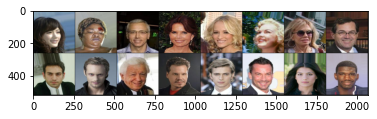

['The woman has an oval face. Her hair is black and wavy. She has a slightly open mouth and narrow eyes. She looks attractive, young, is smiling and has heavy makeup. She is wearing lipstick.', 'The woman has a chubby face and has pretty high cheekbones. She has a big nose and narrow eyes. The lady seems young.', 'The male has high cheekbones. His hair is gray and receding. He has a slightly open mouth. The man is smiling. He is wearing eyeglasses.', 'The lady has high cheekbones. Her hair is brown and wavy. She has arched eyebrows, big lips, a slightly open mouth, narrow eyes and a pointy nose. She looks young, is smiling and has heavy makeup. She is wearing earrings and lipstick.', 'The lady has high cheekbones and an oval face. She has blond and wavy hair. She has bushy eyebrows, a slightly open mouth and a pointy nose. The female is smiling, seems attractive, young and has heavy makeup. She is wearing lipstick.', 'The female has high cheekbones. She has blond and wavy hair. She has

In [ ]:
show_grid(torchvision.utils.make_grid(plt_images[f'output_{image_size}'].cpu(), normalize=True))
print(plt_labels)

In [ ]:
fixed_noise = torch.randn(size=(len(plt_labels), noise_size)).cuda()
def plot_output():
  plt.clf()
  with torch.no_grad():

    netG.eval()
    test_images = netG(fixed_embeddings, fixed_noise)
    netG.train()
  
  show_grid(torchvision.utils.make_grid(test_images[-3].cpu(), normalize=True))


# Training Loop

In [ ]:
netG = Generator(sent_dim=768, noise_dim=100, emb_dim=128, hid_dim=128, max_size=image_size, num_resblock=1)
netD = Discriminator(num_chan=3, hid_dim=128, sent_dim=768, emb_dim=128, max_size=image_size)

try:
    saved_path = '/content/drive/My Drive/Incubator/saved_models/HDGAN256_50k/'

    print('Checking saved path...')
    netG.load_state_dict(torch.load(saved_path + 'generator.pt'))
    netD.load_state_dict(torch.load(saved_path + 'discriminator.pt'))
except:
    print('Training model from scratch')

netG.cuda().train()
netD.cuda().train()

>> Init HDGAN Generator
	 side output at [64, 128, 256]
>> Init HDGAN Discriminator
	 Add adversarial loss at scale [64, 128, 256]
Checking saved path...


Discriminator(
  (img_encoder_64): ImageDown(
    (node): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (3): Sequential(
        (0): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [ ]:
def save_models():
    saved_path = '/content/drive/My Drive/Incubator/saved_models/HDGAN256_50k/'
    netG.cpu().eval()
    netD.cpu().eval()
    torch.save(netG.state_dict(), saved_path + 'generator.pt')
    torch.save(netD.state_dict(), saved_path + 'discriminator.pt')
    netG.cuda().train()
    netD.cuda().train()

In [ ]:
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

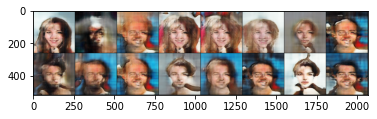

In [ ]:
plot_output()

## Start Training

Epoch: 1 / 20


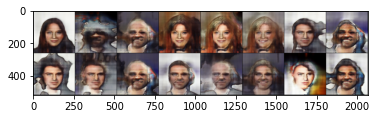

Discriminator Loss: 1.490, Generator Loss: 6.822


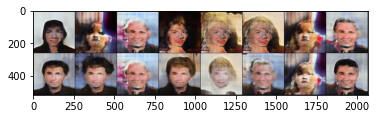

Discriminator Loss: 1.432, Generator Loss: 6.860
Epoch: 2 / 20


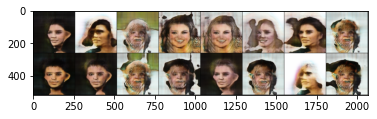

Discriminator Loss: 1.289, Generator Loss: 6.872


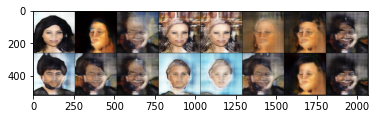

Discriminator Loss: 1.259, Generator Loss: 6.893
Epoch: 3 / 20


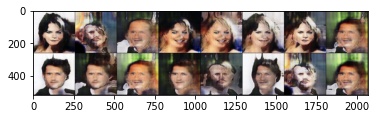

Discriminator Loss: 1.236, Generator Loss: 6.862


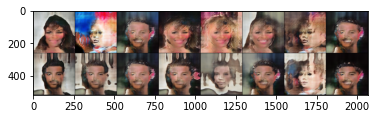

Discriminator Loss: 1.211, Generator Loss: 6.880
Epoch: 4 / 20


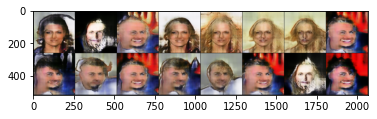

Discriminator Loss: 1.105, Generator Loss: 6.910


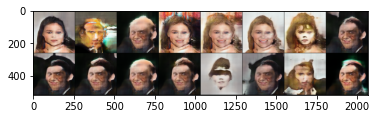

Discriminator Loss: 1.069, Generator Loss: 6.939
Epoch: 5 / 20


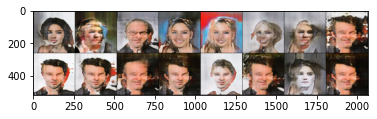

Discriminator Loss: 1.119, Generator Loss: 6.929


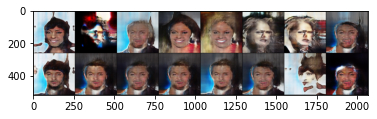

Discriminator Loss: 1.091, Generator Loss: 6.924
Epoch: 6 / 20


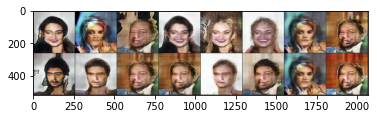

Discriminator Loss: 0.995, Generator Loss: 6.834


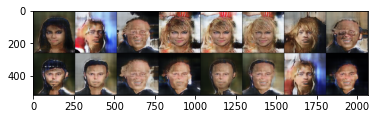

Discriminator Loss: 1.025, Generator Loss: 6.867
Epoch: 7 / 20


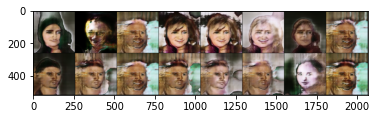

Discriminator Loss: 0.974, Generator Loss: 6.996


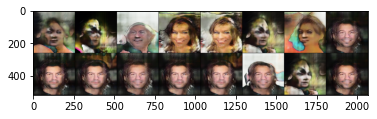

Discriminator Loss: 0.958, Generator Loss: 6.987
Epoch: 8 / 20


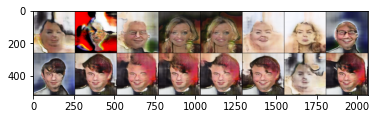

Discriminator Loss: 0.964, Generator Loss: 6.943


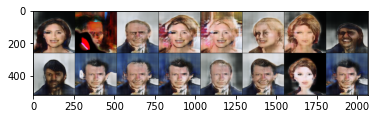

Discriminator Loss: 0.955, Generator Loss: 6.961
Epoch: 9 / 20


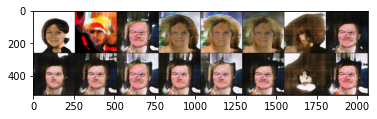

Discriminator Loss: 0.894, Generator Loss: 6.986


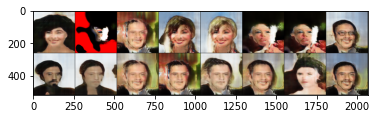

Discriminator Loss: 0.893, Generator Loss: 6.915
Epoch: 10 / 20


KeyboardInterrupt: ignored

In [ ]:
pbar = tqdm()

for epoch in range(epochs):
    torch.cuda.empty_cache()
    print(f'Epoch: {epoch + 1} / {epochs}')
    pbar.reset(total=len(weighted_dataloader))

    # Setting up losses
    discriminator_losses = []
    generator_losses = []

    for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
        current_batch_size = len(real_text)

        # Critic
        for _ in range(n_critic):
            embeddings = sentence_encoder.convert_text_to_embeddings(real_text)
            z = torch.randn(size=(current_batch_size, noise_size)).cuda()

            for p in netD.parameters(): p.requires_grad = True
            netD.zero_grad()

            fake_images, mean_var = to_img_dict(netG(embeddings, z))

            discriminator_loss = 0
            # Iterate over images of different sizes
            for key, _ in fake_images.items():
                this_img = real_images[key].cuda()
                this_wrong = wrong_images[key].cuda()
                this_fake = fake_images[key].data

                real_logit,  real_img_logit_local = netD(this_img, embeddings)
                wrong_logit, wrong_img_logit_local = netD(this_wrong, embeddings)
                fake_logit,  fake_img_logit_local = netD(this_fake, embeddings)

                ''' compute disc pair loss '''
                real_labels, fake_labels = torch.ones_like(real_logit).cuda(), torch.zeros_like(fake_logit).cuda()
                pair_loss = compute_d_pair_loss(real_logit, wrong_logit, fake_logit, real_labels, fake_labels)

                ''' compute disc image loss '''
                real_labels, fake_labels = torch.ones_like(real_img_logit_local).cuda(), torch.zeros_like(wrong_img_logit_local).cuda()
                img_loss = compute_d_img_loss(wrong_img_logit_local, real_img_logit_local, fake_img_logit_local, real_labels, fake_labels)

                discriminator_loss += (pair_loss + img_loss)
            discriminator_loss.backward()
            optimizerD.step()
            netD.zero_grad()
            d_loss_val = to_numpy(discriminator_loss).mean()
            discriminator_losses.append(d_loss_val)
            # d_loss_plot.plot(d_loss_val)

        for p in netD.parameters(): p.requires_grad = False  # to avoid computation
        netG.zero_grad()

        loss_val = 0
        if type(mean_var) == tuple:
            kl_loss = get_KL_Loss(mean_var[0], mean_var[1])
            kl_loss_val = to_numpy(kl_loss).mean()
            generator_loss = KL_COE * kl_loss
        else:
            # when trian 512HDGAN. KL loss is fixed since we assume 256HDGAN is trained.
            # mean_var actually returns pixel-wise l1 loss (see paper)
            generator_loss = mean_var
        

        '''Compute gen loss'''
        for key, _ in fake_images.items():
            this_fake = fake_images[key]
            fake_pair_logit, fake_img_logit_local = netD(this_fake, embeddings)

            # -- compute pair loss ---
            real_labels = torch.ones_like(fake_pair_logit)
            generator_loss += compute_g_loss(fake_pair_logit, real_labels)

            # -- compute image loss ---
            real_labels = torch.ones_like(fake_img_logit_local)
            img_loss = compute_g_loss(fake_img_logit_local, real_labels)
            generator_loss += img_loss

        generator_loss.backward()
        optimizerG.step()
        netG.zero_grad()
        g_loss_val = to_numpy(generator_loss).mean()

        generator_losses.append(g_loss_val)

        if (i + 1) % (len(weighted_dataloader) // 2) == 0:
            plot_output()
            save_models()
            print('Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format(
                torch.mean(torch.FloatTensor(discriminator_losses)),
                torch.mean(torch.FloatTensor(generator_losses))
          ))

        # Update tqdm
        pbar.update()

pbar.refresh()